In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
L = 1.0
k = 1.0

# Build the PINN model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = [
            tf.keras.layers.Dense(64, activation='tanh') for _ in range(3)
        ]
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, X):
        x = X
        for layer in self.hidden:
            x = layer(x)
        return self.output_layer(x)

# Initial condition
def initial_condition(x):
    return 6 * np.sin(np.pi * x / L)

# Define physics-informed residual
def compute_residual(model, x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        X = tf.concat([x, t], axis=1)
        u = model(X)

        u_t = tape.gradient(u, t)
        u_x = tape.gradient(u, x)
    u_xx = tape.gradient(u_x, x)
    del tape
    return u_t - k * u_xx

# Training data
N_f = 10000  # Collocation points
N_b = 200    # Boundary points
N_i = 200    # Initial points

# Collocation (interior) points
x_f = tf.random.uniform((N_f, 1), 0, L)
t_f = tf.random.uniform((N_f, 1), 0, 1)

# Initial condition points
x_i = tf.random.uniform((N_i, 1), 0, L)
t_i = tf.zeros((N_i, 1))
u_i = initial_condition(x_i.numpy())

# Boundary points
t_b = tf.random.uniform((N_b, 1), 0, 1)
x_0 = tf.zeros((N_b, 1))
x_L = tf.ones((N_b, 1)) * L

# Model
model = PINN()
optimizer = tf.keras.optimizers.Adam()

# Training
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        # Interior loss (PDE residual)
        res = compute_residual(model, x_f, t_f)
        loss_f = tf.reduce_mean(tf.square(res))

        # Initial condition loss
        u_pred_i = model(tf.concat([x_i, t_i], axis=1))
        loss_i = tf.reduce_mean(tf.square(u_pred_i - u_i))

        # Boundary condition loss
        u_0 = model(tf.concat([x_0, t_b], axis=1))
        u_L = model(tf.concat([x_L, t_b], axis=1))
        loss_b = tf.reduce_mean(tf.square(u_0)) + tf.reduce_mean(tf.square(u_L))

        # Total loss
        total_loss = loss_f + loss_i + loss_b

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss

# Training loop
for epoch in range(5000):
    loss = train_step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy():.5f}")


Epoch 0: Loss = 19.15429
Epoch 500: Loss = 0.02136
Epoch 1000: Loss = 0.00379
Epoch 1500: Loss = 0.00183
Epoch 2000: Loss = 0.00645
Epoch 2500: Loss = 0.00069
Epoch 3000: Loss = 0.01085
Epoch 3500: Loss = 0.00072
Epoch 4000: Loss = 0.00114
Epoch 4500: Loss = 0.00041


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


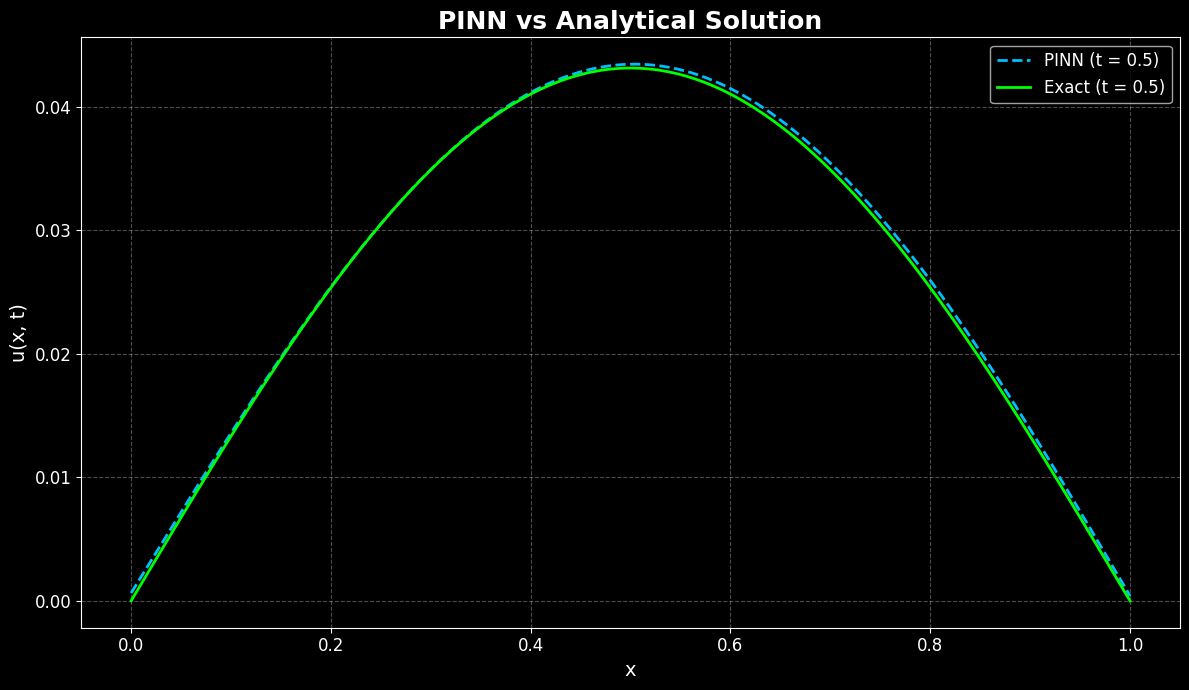

In [4]:
L = 1.0
k = 1.0

# Set dark background
plt.style.use('dark_background')

# Time slice and spatial domain
time_slices = [0.5]
x_plot = np.linspace(0, L, 200)

plt.figure(figsize=(12, 7))

for t_val in time_slices:
    x_input = x_plot.reshape(-1, 1)
    t_input = np.full_like(x_input, t_val)
    XT_input = np.hstack((x_input, t_input))
    
    # PINN prediction (dummy in this case)
    u_pred = model.predict(XT_input).flatten()
    
    # Analytical solution
    u_exact = 6 * np.sin(np.pi * x_input.flatten()) * np.exp(-k * (np.pi / L) ** 2 * t_val)
    
    plt.plot(x_plot, u_pred, '--', linewidth=2, color='deepskyblue', label=f'PINN (t = {t_val})')
    plt.plot(x_plot, u_exact, '-', linewidth=2, color='lime', label=f'Exact (t = {t_val})')

plt.title("PINN vs Analytical Solution", fontsize=18, weight='bold', color='white')
plt.xlabel("x", fontsize=14, color='white')
plt.ylabel("u(x, t)", fontsize=14, color='white')
plt.xticks(fontsize=12, color='white')
plt.yticks(fontsize=12, color='white')
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
print(x_f)

tf.Tensor(
[[0.98884845]
 [0.29528415]
 [0.10077608]
 ...
 [0.38625133]
 [0.38839054]
 [0.07602179]], shape=(10000, 1), dtype=float32)
